In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Introduction to Real Business Cycle Modeling

Real business cycle (RBC) models are extensions of the stochastic Solow model. RBC models replace the ad hoc assumption of a constant saving rate in the Solow model with the solution to an intertemporal utility maximization problem that gives rise to a variable saving rate. RBC models also often feature some sort of household labor-leisure tradeoff that produces endogenous labor varation.

In this notebook, we'll consider a baseline RBC model that does not have labor. We'll use the model to compute impulse responses to a one percent shock to TFP.

## The Baseline RBC Model without Labor

The equilibrium conditions for the RBC model without labor are:

\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1} +1-\delta }{C_{t+1}}\right]\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = A_t K_t^{\alpha}\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The objective is use `linearsolve` to simulate impulse responses to a TFP shock using the following parameter values for the simulation:

| $\rho$ | $\sigma$ | $\beta$ | $\alpha$ | $\delta $ | $T$ |
|--------|----------|---------|----------|-----------|-----|
| 0.75   | 0.006    | 0.99    | 0.35     |  0.025    | 26  |

## Model Preparation

Before proceding, let's recast the model in the form required for `linearsolve`. Write the model with all variables moved to the lefthand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:

\begin{align}
0 & = \beta\left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1} +1-\delta }{C_{t+1}}\right] - \frac{1}{C_t}\\
0 & = A_t K_t^{\alpha} - Y_t\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = C_t + I_t - Y_t\\
0 & = \rho \log A_t - \log A_{t+1}
\end{align}

Remember, capital and TFP are called *state variables* because they're $t+1$ values are predetermined. Output, consumption, and investment are called a *costate* or *control* variables. Note that the model as 5 equations in 5 endogenous variables.



## Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series
parameters = pd.Series()
parameters['rho'] = .75
parameters['sigma_squared'] = 0.006**2
parameters['beta'] = 0.99
parameters['alpha'] = 0.35
parameters['delta'] = 0.025

# Print the model's parameters
print(parameters)

rho              0.750000
sigma_squared    0.000036
beta             0.990000
alpha            0.350000
delta            0.025000
dtype: float64


In [3]:
# Create variable called 'varNames' that stores the variable names in a list with state variables ordered first
varNames = ['a','k','y','c','i']

# Create variable called 'shockNames' that stores an exogenous shock name for each state variable.
shockNames = ['e_a','e_k']

In [4]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # Euler equation
    euler_equation = p.beta*(p.alpha*fwd.a*fwd.k**(p.alpha-1)+1-p.delta)/fwd.c - 1/cur.c
    
    # Production function
    production_function = cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    # Market clearing
    market_clearing = cur.c+cur.i - cur.y
    
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        production_function,
        capital_evolution,
        market_clearing,
        tfp_process
        ])

Next, initialize the model using `ls.model` which takes the following required arguments:

* `equations`
* `nstates`
* `varNames`
* `shockNames`
* `parameters`

In [5]:
# Initialize the model into a variable named 'rbc_model'
rbc_model = ls.model(equations = equilibrium_equations,
                 nstates=2,
                 varNames=varNames,
                 shockNames=shockNames,
                 parameters=parameters)

In [6]:
# Compute the steady state numerically using .compute_ss() method of rbc_model
guess = [1,4,1,1,1]
rbc_model.compute_ss(guess)

# Print the computed steady state
print(rbc_model.ss)

a     1.000000
k    34.398226
y     3.449750
c     2.589794
i     0.859956
dtype: float64


In [7]:
# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of rbc_model
rbc_model.approximate_and_solve()

### Impulse Responses

Compute a 26 period impulse responses of the model's variables to a 0.01 unit shock to TFP in period 5.

In [8]:
# Compute impulse responses
rbc_model.impulse(T=26,t0=5,shocks=[0.01,0])

# Print the first 10 rows of the computed impulse responses to the TFP shock
print(rbc_model.irs['e_a'].head(10))

    e_a         a         k         y         c         i
0  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
2  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
3  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
4  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
5  0.01  0.010000  0.000000  0.010000  0.001253  0.036342
6  0.00  0.007500  0.000909  0.007818  0.001493  0.026865
7  0.00  0.005625  0.001557  0.006170  0.001654  0.019772
8  0.00  0.004219  0.002013  0.004923  0.001755  0.014465
9  0.00  0.003164  0.002324  0.003978  0.001812  0.010499


Construct a $2\times2$ grid of plots of simulated TFP, output, consumption, and investment. Be sure to multiply simulated values by 100 so that vertical axis units are in "percent deviation from steady state."

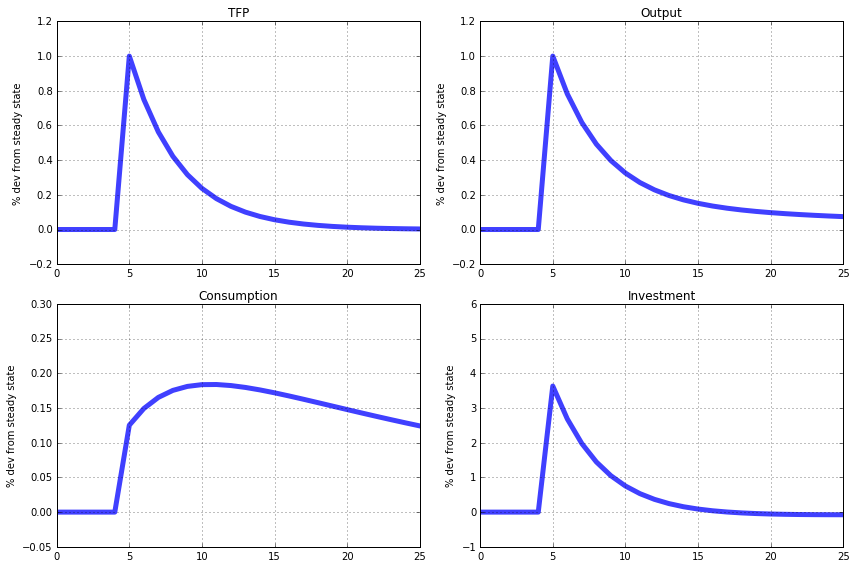

In [9]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,8))

# Create upper-left axis. PROVIDED
ax = fig.add_subplot(2,2,1)
ax.plot(rbc_model.irs['e_a']['a']*100,'b',lw=5,alpha=0.75)
ax.set_title('TFP')
ax.set_ylabel('% dev from steady state')
ax.set_ylim([-0.2,1.2])
ax.grid()

# Create upper-right axis. PROVIDED
ax = fig.add_subplot(2,2,2)
ax.plot(rbc_model.irs['e_a']['y']*100,'b',lw=5,alpha=0.75)
ax.set_title('Output')
ax.set_ylabel('% dev from steady state')
ax.set_ylim([-0.2,1.2])
ax.grid()

# Create lower-left axis. PROVIDED
ax = fig.add_subplot(2,2,3)
ax.plot(rbc_model.irs['e_a']['c']*100,'b',lw=5,alpha=0.75)
ax.set_title('Consumption')
ax.set_ylabel('% dev from steady state')
ax.set_ylim([-0.05,0.30])
ax.grid()

# Create lower-right axis. PROVIDED
ax = fig.add_subplot(2,2,4)
ax.plot(rbc_model.irs['e_a']['i']*100,'b',lw=5,alpha=0.75)
ax.set_title('Investment')
ax.set_ylabel('% dev from steady state')
ax.set_ylim([-1,6])
ax.grid()

fig.tight_layout()